# Task
Count and embed the stories from the provided JSON files, then find the stories most related to "raise tension in couple after the birth of a child".

## List and load files

### Subtask:
Identify all the relevant JSON files and load their content into a structured format (e.g., a list of dictionaries or a pandas DataFrame).


**Reasoning**:
Identify all the relevant JSON files and load their content into a structured format.



In [ ]:
import glob
import json
import pandas as pd

# Find all files ending with '_submissions.txt' in the /content/ directory
file_paths = glob.glob('/content/drive/MyDrive/reddit_data/*_submissions.txt')

# Initialize an empty list to store the loaded data
all_submissions = []

# Iterate through the file paths and load JSON content
for file_path in file_paths:
    print(file_path)
    with open(file_path, 'r') as f:

        stories = [json.loads(line) for line in f if line.strip()]
        all_submissions.extend(stories)

# Convert the list of dictionaries to a pandas DataFrame
df = pd.DataFrame(all_submissions)

# Display the first few rows of the DataFrame
display(df.head())

/content/drive/MyDrive/reddit_data/BabyBumpsCanada_submissions.txt
/content/drive/MyDrive/reddit_data/ToxicRelationships_submissions.txt
/content/drive/MyDrive/reddit_data/relationship_tips_submissions.txt
/content/drive/MyDrive/reddit_data/relationships_submissions.txt
/content/drive/MyDrive/reddit_data/ParentingADHD_submissions.txt
/content/drive/MyDrive/reddit_data/Parenting_submissions.txt
/content/drive/MyDrive/reddit_data/abusiverelationships_submissions.txt
/content/drive/MyDrive/reddit_data/BabyBumps_submissions.txt
/content/drive/MyDrive/reddit_data/marriageadvice_submissions.txt
/content/drive/MyDrive/reddit_data/ParentingInBulk_submissions.txt
/content/drive/MyDrive/reddit_data/ParentingFR_submissions.txt
/content/drive/MyDrive/reddit_data/RelationshipsOver35_submissions.txt
/content/drive/MyDrive/reddit_data/BabyBumpsandBeyondAu_submissions.txt
/content/drive/MyDrive/reddit_data/AITA_Relationships_submissions.txt
/content/drive/MyDrive/reddit_data/relationshipadvice_submiss

,title,selftext
0,"Any teachers on here (preferably in BC, but op...",I was very newly pregnant when I interviewed f...
1,Does it matter which hospital you give birth at?,This is kind of a unique situation I suppose b...
2,"Flying with Baby - Porter, Air Canada, Westjet","I live long distance from my family, and I'm l..."
3,Winter Jacket Insert (for pregnancy and with b...,First—apologies to the mods if I’ve posted too...
4,Parental Leave - Alberta,"Hello, Im currently 29 weeks today with my fir..."


**Reasoning**:
The previous attempt to load the JSON data failed because some files likely contain multiple JSON objects not enclosed in a list. I will modify the code to load each line as a separate JSON object and handle potential errors during parsing.



In [ ]:
# Print the number of rows loaded
print(f"Number of rows loaded: {len(df)}")

Number of rows loaded: 114087


## Count entries

### Subtask:
Iterate through the loaded data and count the total number of stories across all files.


**Reasoning**:
Get the number of rows in the DataFrame `df` and store it in a variable named `total_stories`, then print the result.



In [ ]:
total_stories = len(df)
print(f"Total number of stories: {total_stories}")

Total number of stories: 114087


## Preprocess text

### Subtask:
Clean and preprocess the text data (title and selftext) to prepare it for embedding. This may include removing special characters, punctuation, and converting to lowercase.


**Reasoning**:
Clean and preprocess the text data in the 'title' and 'selftext' columns and store the result in a new 'cleaned_text' column, handling missing values, converting to lowercase, and removing URLs, punctuation, and extra whitespace.



In [ ]:
import re
import string

# Combine 'title' and 'selftext' columns, treating missing values as empty strings
df['cleaned_text'] = df['title'].fillna('') + ' ' + df['selftext'].fillna('')

# Convert text to lowercase
df['cleaned_text'] = df['cleaned_text'].str.lower()

# Remove URLs
df['cleaned_text'] = df['cleaned_text'].apply(lambda x: re.sub(r'http\S+|www.\S+', '', x))

# Remove punctuation
df['cleaned_text'] = df['cleaned_text'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

# Remove special characters (keeping alphanumeric and whitespace)
df['cleaned_text'] = df['cleaned_text'].apply(lambda x: re.sub(r'[^a-zA-Z0-9\s]', '', x))

# Remove extra whitespace, including leading and trailing whitespace
df['cleaned_text'] = df['cleaned_text'].apply(lambda x: re.sub(r'\s+', ' ', x).strip())

# Display the first few rows with the new cleaned_text column
display(df[['title', 'selftext', 'cleaned_text']].head())

,title,selftext,cleaned_text
0,"Any teachers on here (preferably in BC, but op...",I was very newly pregnant when I interviewed f...,any teachers on here preferably in bc but open...
1,Does it matter which hospital you give birth at?,This is kind of a unique situation I suppose b...,does it matter which hospital you give birth a...
2,"Flying with Baby - Porter, Air Canada, Westjet","I live long distance from my family, and I'm l...",flying with baby porter air canada westjet i l...
3,Winter Jacket Insert (for pregnancy and with b...,First—apologies to the mods if I’ve posted too...,winter jacket insert for pregnancy and with ba...
4,Parental Leave - Alberta,"Hello, Im currently 29 weeks today with my fir...",parental leave alberta hello im currently 29 w...


## Embed text

### Subtask:
Generate embeddings for each story's text using a suitable embedding model.


**Reasoning**:
Generate embeddings for the 'cleaned_text' column using a pre-trained SentenceTransformer model and store them in a new column.



In [ ]:
from sentence_transformers import SentenceTransformer
import numpy as np

# Load a pre-trained sentence embedding model
model = SentenceTransformer('all-MiniLM-L6-v2')

emb = model.encode(df['cleaned_text'].tolist(), batch_size=32, show_progress_bar=True)



Batches:   0%|          | 0/3566 [00:00<?, ?it/s]

In [ ]:
df["embedding"] = [row.astype(float).tolist() for row in emb]

## Find most relevant stories

### Subtask:
Calculate the similarity between the query embedding and each story embedding, and identify the stories with the highest similarity scores.

**Reasoning**:
Calculate the cosine similarity between the query embedding and each story embedding and store the results in a new column, then find the indices of the top N most similar stories and display the corresponding rows from the original DataFrame.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Define the query
query = "raise tension in couple after the birth of a child"

# Generate the embedding for the query
query_embedding = model.encode([query])[0]

# Calculate cosine similarity between the query embedding and all story embeddings
df['similarity'] = df['embedding'].apply(lambda x: cosine_similarity([query_embedding], [x])[0][0])

# Get the indices of the top N most similar stories
top_n = 10  # You can adjust N as needed
top_n_indices = df.nlargest(top_n, 'similarity').index

# Display the top N most similar stories
most_relevant_stories = df.loc[top_n_indices]

display(most_relevant_stories[['title', 'selftext', 'similarity']])

,title,selftext,similarity
56536,Navigating family tensions around New Baby,[removed],0.676542
101226,Healthy marriages before baby arrives,The hormones and added stress of everything we...,0.643888
106502,Relationships after baby,"First time mom, due January 29th! I keep readi...",0.641084
60499,Relationship help with a newborn,What are your favorite tips for helping your r...,0.636095
79928,Resenting your partner after having a baby,This isn’t about me resenting my partner but m...,0.628715
105134,Looking for coping ideas,How do you and your partner deal with the lows...,0.623433
47285,New Parents and New Problems,My husband and I are in our mid-twenties and w...,0.613916
79813,"New parents, question about marriage",So me (25) and my wife (21) are new parents. O...,0.609367
65961,"Parents who still have good intimacy, how did ...",[removed],0.593871
105415,Looking for advice to share with partner about...,My partner and I are expecting our first. They...,0.593408


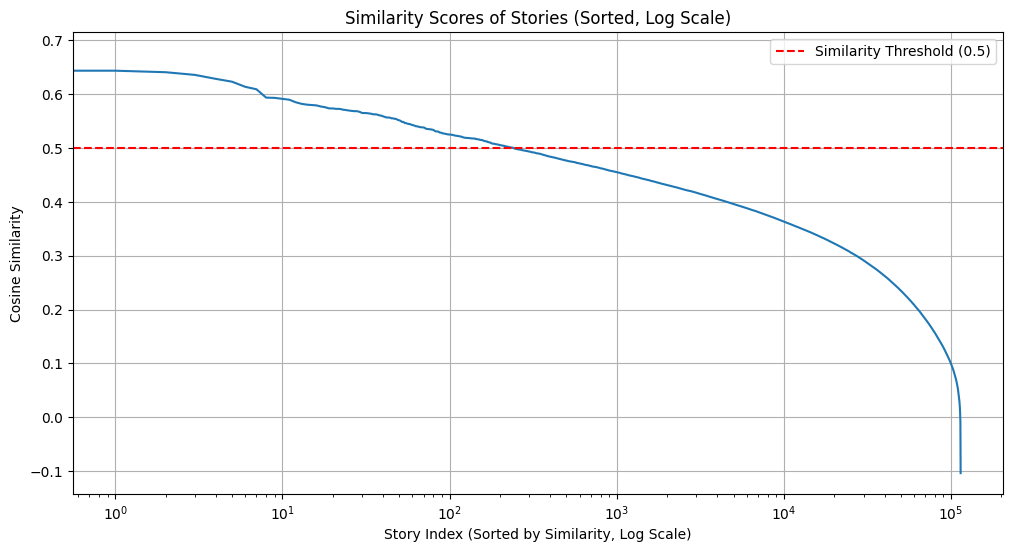

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Sort the DataFrame by similarity score in descending order
df_sorted = df.sort_values(by='similarity', ascending=False)

# Plot the similarity scores
plt.figure(figsize=(12, 6))
sns.lineplot(x=range(len(df_sorted)), y=df_sorted['similarity'])

# Set x-axis to logarithmic scale
plt.xscale('log')

# Add a horizontal line at the 0.5 similarity threshold
plt.axhline(y=0.5, color='r', linestyle='--', label='Similarity Threshold (0.5)')


plt.title('Similarity Scores of Stories (Sorted, Log Scale)')
plt.xlabel('Story Index (Sorted by Similarity, Log Scale)')
plt.ylabel('Cosine Similarity')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# Filter stories with similarity score above the threshold (e.g., 0.5)
relevant_stories = df_sorted[df_sorted['similarity'] >= 0.5]


# Define the output file path
output_file = '/content/top_250_stories.txt'

# Write the title and selftext of each story to the file
with open(output_file, 'w', encoding='utf-8') as f:
    for index, row in relevant_stories.iterrows():
        f.write(f"Title: {row['title']}\n")
        f.write(f"Story: {row['selftext']}\n")
        f.write("-" * 50 + "\n") # Separator between stories

print(f"Top 250 stories exported to {output_file}")

Top 250 stories exported to /content/top_250_stories.txt


In [ ]:
# Save the DataFrame to Google Drive
output_path = '/content/drive/MyDrive/reddit_data/processed_reddit_stories.csv'
df_sorted.to_csv(output_path, index=False)

print(f"DataFrame saved to {output_path}")

DataFrame saved to /content/drive/MyDrive/reddit_data/processed_reddit_stories.csv


In [ ]:
import pandas as pd

# Define the path to the saved DataFrame in Google Drive
input_path = '/content/drive/MyDrive/reddit_data/processed_reddit_stories.csv'

# Load the DataFrame
df = pd.read_csv(input_path)

# Display the first few rows to confirm it's loaded
display(df.head())

# Filter stories with similarity score above the threshold (e.g., 0.5)
relevant_stories = df[df['similarity'] >= 0.5]

,title,selftext,cleaned_text,embedding,similarity
0,Navigating family tensions around New Baby,[removed],navigating family tensions around new baby rem...,"[-0.04365828260779381, 0.02725449949502945, 0....",0.676542
1,Healthy marriages before baby arrives,The hormones and added stress of everything we...,healthy marriages before baby arrives the horm...,"[-0.03230593726038933, -0.01977657712996006, -...",0.643888
2,Relationships after baby,"First time mom, due January 29th! I keep readi...",relationships after baby first time mom due ja...,"[-0.02334958128631115, -0.04716073349118233, 0...",0.641084
3,Relationship help with a newborn,What are your favorite tips for helping your r...,relationship help with a newborn what are your...,"[-0.04770377650856972, 3.0367295039468445e-05,...",0.636095
4,Resenting your partner after having a baby,This isn’t about me resenting my partner but m...,resenting your partner after having a baby thi...,"[0.0010647607268765569, -0.06055992841720581, ...",0.628715


In [ ]:
# Assuming 'relevant_stories' DataFrame is already created from the previous step

question_context = """

I want you to analyse the reddit story I just sent you, the goal is to give me back with some informations:
- Firstly I want to get the profile of the user : age of the couple, supposed income range, living with nuclear or extented family
- Secondly I want to categorize the story into multiple issue.
Please provide your answer as a json filing the following template :
{
  "age_group":"supposed age here",
  "income_group":"low income|medium income|high income",
  "family_type":"nuclear|extented",
  "number_child":"number of child",
  "categorisation":{
    "communication_issue":{
      "attention":"score from one to ten about lack of giving attention between member",
      "miscommunication":"score from one to ten about lack of communication"
    },
    "society":{
      "mass_media":"score from one to ten about the pressure experienced from the social network, perfect instagram life...",
      "personnal_circle":"score from one to ten about the pressure experienced from the distance with friend family...",
      "career":"score from one to ten about the pressure experience by income, career change..."
    },
    "private_life":{
      "natural_gender_gap":"score from one to ten about the physiological difference experienced by the couple",
      "emotional_inteligence":"score from one to ten about the miscomprehension of the other one gender"
    }
  }
}

YOU HAVE ONLY RIGHT TO ANSWER A JSON
"""

# Import the necessary libraries for Gemini API
import google.generativeai as genai
from google.colab import userdata
import json
import re
import time

# Configure the Gemini API (assuming your API key is stored in Colab secrets as 'GOOGLE_API_KEY')
GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')
genai.configure(api_key=GOOGLE_API_KEY)

# Initialize the Generative Model (replace 'gemini-pro' with the desired model)
gemini_model = genai.GenerativeModel('gemini-2.5-flash-lite')

result = []

# Iterate through the top 250 stories
for index, story in relevant_stories.iterrows():

    if index < 0 :
      continue

    story_title = story['title']
    story_text = story['selftext']

    prompt = "START_OF_REDDIT_STORY\n\n" + str(story_text) + "\n\n END_OF_REDDIT_STORY" + question_context

    # TODO: Add your Gemini API call here
    # Example:
    # prompt = f"Analyze the following story and provide insights on [your question]:\nTitle: {story_title}\nStory: {story_text}"
    # response = gemini_model.generate_content(prompt)
    # print(f"Insights for story {index}:\n{response.text}\n")

    # You can access other columns of the story DataFrame row as needed
    # story_similarity = story['similarity']
    # story_cleaned_text = story['cleaned_text']

    #debug
    while True :
      try:
        response= gemini_model.generate_content(prompt)
        break
      except Exception as e:
        print(f"Error generating content for story {index}: {e}")
        time.sleep(5)


    # Process the Gemini response to extract and parse JSON
    try:
        # Remove markdown code block if present
        json_string = re.search(r'```json\n(.*?)```', response.text, re.DOTALL)
        if json_string:
            json_data = json.loads(json_string.group(1))
        else:
            # Assume the response is directly JSON
            json_data = json.loads(response.text)

            relevant_stories.at[index,"gemini_result"] = json_data

        # Now you can work with the extracted json_data dictionary
        print(f"Parsed JSON data for story {index}: {json_data}\n")



    except json.JSONDecodeError as e:
        print(f"Error decoding JSON for story {index}: {e}\nResponse text: {response.text}\n")
    except Exception as e:
        print(f"An unexpected error occurred for story {index}: {e}\nResponse text: {response.text}\n")

    time.sleep(60/15)
